### Transformer for CIFAR10

A configurable transformer model will be used for CIFAR10 image classification. 

The vision transformer model is a modified version of ViT. The changes are:
1) No position embedding.
2) No dropout is used.
3) All encoder features are used for class prediction.

The code below is a simplified version of Timm modules.

Let us import the required packages.

In [71]:
import torch
import torchvision

from argparse import ArgumentParser
from pytorch_lightning import LightningModule, Trainer, LightningDataModule
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.functional import accuracy
from einops import rearrange
from torch import nn
from torchvision.datasets.cifar import CIFAR10

### Attention Module

The `Attention` module is the core of the vision transformer model. It implements the attention mechanism:

1) Multiply QKV by their weights
2) Perform dot product on Q and K. 
3) Normalize the result in 2) by sqrt of `head_dim`  
4) Softmax is applied to the result.
5) Perform dot product on the result of 4) and V and the result is the output.

In [72]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x

### MLP Module

The MLP module is a made of two linear layers. A non-linear activation is applied to the output of the first layer.

In [73]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
      
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

### The Block Module

The `Block` module represents one encoder transformer block. It consists of two sub-modules:
1) The Attention module
2) The MLP module

Layer norm is applied before and after the Attention module.

In [74]:
class Block(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, 
            act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias) 
        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer) 
   

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

### The Transformer Module

The feature encoder is made of several transformer blocks. The most important attributes are:
1) `depth` : representing the number of encoder blocks
2) `num_heads` : representing the number of attention heads

In [75]:
class Transformer(nn.Module):
    def __init__(self, dim, num_heads, num_blocks, mlp_ratio=4., qkv_bias=False,  
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, num_heads, mlp_ratio, qkv_bias, 
                                     act_layer, norm_layer) for _ in range(num_blocks)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

#### The optional parameter initialization as adopted from `timm`

In [76]:
def init_weights_vit_timm(module: nn.Module):
    """ ViT weight initialization, original timm impl (for reproducibility) """
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()

### PyTorch Lightning for CIFAR10 Image Classification

We use the `Transformer` module to build the feature encoder. Before the `Transformer` can be used, we convert the input image into patches. The patches are then embedded into a linear space. The output is then passed to the Transformer.

Another difference between this model is we use all output features for the final classification. In the ViT, only the first feature is used.



In [77]:

class LitTransformer(LightningModule):
    def __init__(self, num_classes=10, lr=0.001, max_epochs=30, depth=12, embed_dim=64,
                 head=4, patch_dim=192, seqlen=16, **kwargs):
        super().__init__()
        print('_'*20, 'init')
        self.save_hyperparameters()
        self.encoder = Transformer(dim=embed_dim, num_heads=head, num_blocks=depth, mlp_ratio=4.,
                                   qkv_bias=False, act_layer=nn.GELU, norm_layer=nn.LayerNorm)
        self.embed = torch.nn.Linear(patch_dim, embed_dim)

        self.fc = nn.Linear(seqlen * embed_dim, num_classes)
        self.loss = torch.nn.CrossEntropyLoss()
        
        self.reset_parameters()


    def reset_parameters(self):
        print('_'*20, 'reset param')
        init_weights_vit_timm(self)
    

    def forward(self, x):
        print('_'*20, 'fwd')
        # Linear projection
        x = self.embed(x)
            
        # Encoder
        x = self.encoder(x)
        x = x.flatten(start_dim=1)

        # Classification head
        x = self.fc(x)
        return x
    
    def configure_optimizers(self):
        print('_'*20, 'config optimizers')
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        print('_'*20, 'steps')
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        return loss
    

    def test_step(self, batch, batch_idx):
        # print('_'*20, 'test step')
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        acc = accuracy(y_hat, y)
        return {"y_hat": y_hat, "test_loss": loss, "test_acc": acc}

    def test_epoch_end(self, outputs):
        # print('_'*20, 'test ep end')
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["test_acc"] for x in outputs]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc*100., on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        # print('_'*20, 'valid step')
        return self.test_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        # print('_'*20, 'vald epoc end')
        return self.test_epoch_end(outputs)



In [78]:

# a lightning data module for cifar 10 dataset
class LitCifar10(LightningDataModule):
    def __init__(self, batch_size=32, num_workers=32, patch_num=4, **kwargs):
        print('_'*20, 'datamodule init')
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.patch_num = patch_num

    def prepare_data(self):
        print('_'*20, 'datamodule prepare data')
        self.train_set = CIFAR10(root='./data', train=True,
                                 download=True, transform=torchvision.transforms.ToTensor())
        self.test_set = CIFAR10(root='./data', train=False,
                                download=True, transform=torchvision.transforms.ToTensor())

    def collate_fn(self, batch):
        print('_'*20, 'datamodule collate fn')
        x, y = zip(*batch)
        x = torch.stack(x, dim=0)
        y = torch.LongTensor(y)

        print('\nx before rearrange:{}'.format(x.shape))

        x = rearrange(x, 'b c (p1 h) (p2 w) -> b (p1 p2) (c h w)', p1=self.patch_num, p2=self.patch_num)


        print('xhsape', x.shape)
        print('yhsape', y.shape)
        return x, y

    def train_dataloader(self):
        print('_'*20, 'datamodule train dataloader')
        return torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, 
                                        shuffle=True, collate_fn=self.collate_fn,
                                        num_workers=self.num_workers)

    def test_dataloader(self):
        print('_'*20, 'datamodule test dataload')
        return torch.utils.data.DataLoader(self.test_set, batch_size=self.batch_size, 
                                        shuffle=False, collate_fn=self.collate_fn,
                                        num_workers=self.num_workers)

    def val_dataloader(self):
        print('_'*20, 'datamodule valdataloader')
        return self.test_dataloader()



def get_args():
    parser = ArgumentParser(description='PyTorch Transformer')
    parser.add_argument('--depth', type=int, default=12, help='depth')
    parser.add_argument('--embed_dim', type=int, default=128, help='embedding dimension')
    parser.add_argument('--num_heads', type=int, default=4, help='num_heads')

    parser.add_argument('--patch_num', type=int, default=8, help='patch_num')
    parser.add_argument('--kernel_size', type=int, default=3, help='kernel size')
    parser.add_argument('--batch_size', type=int, default=44, metavar='N',
                        help='input batch size for training (default: )')
    parser.add_argument('--max-epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 0)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.0)')

    parser.add_argument('--accelerator', default='gpu', type=str, metavar='N')
    parser.add_argument('--devices', default=1, type=int, metavar='N')
    parser.add_argument('--dataset', default='cifar10', type=str, metavar='N')
    parser.add_argument('--num_workers', default=16, type=int, metavar='N')
    args = parser.parse_args("")
    return args


### Performance on different settings

The following table shows different performances on different settings. Generally, Transformer is better than MLP in terms of accuracy and parameter count. However, the performance is worse compared to CNN models. 

However, the most important thing to note is that Transformers are more general purpose models than CNNs. They can process different types of data. They can process multiple types of data at the same time. This is why they are considered to be the backbone of many high-performing models like BERT, GPT3, PalM and Gato.

| **Depth** | **Head** | **Embed dim** | **Patch size** | **Seq len** | **Params** | **Accuracy** | 
| -: | -: | -: | -: | -: | -: | -: |
| 12 | 4 | 32 | 4x4 | 64 | 173k | 68.2% |
| 12 | 4 | 64 | 4x4 | 64 | 641k | 71.1% |
| 12 | 4 | 128 | 4x4 | 64 | 2.5M | 71.5% |

In [79]:

args = get_args()

datamodule = LitCifar10(batch_size=args.batch_size,
                        patch_num=args.patch_num, 
                        num_workers=args.num_workers * args.devices)
datamodule.prepare_data()

data = iter(datamodule.train_dataloader()).next()
patch_dim = data[0].shape[-1]
seqlen = data[0].shape[-2]
print("Embed dim:", args.embed_dim)
print("Patch size:", 32 // args.patch_num)
print("Sequence length:", seqlen)

____________________ datamodule init
____________________ datamodule prepare data
Files already downloaded and verified
Files already downloaded and verified
____________________ datamodule train dataloader
____________________ datamodule collate fn

x before rearrange:torch.Size([64, 3, 32, 32])
____________________ torch.Size([64, 64, 48])datamodule collate fn
________________________________________ ____________________ datamodule collate fn________________________________________
________________________________________________________________________________
x before rearrange:torch.Size([64, 3, 32, 32])____________________
    datamodule collate fn datamodule collate fn  xhsapedatamodule collate fndatamodule collate fn
x before rearrange:torch.Size([64, 3, 32, 32])
____________________datamodule collate fndatamodule collate fn 

datamodule collate fn
datamodule collate fntorch.Size([64, 64, 48]) 
torch.Size([64, 64, 48])


datamodule collate fn

x before rearrange:torch.Size([64,

In [70]:
data[0].shape

torch.Size([64, 64, 48])

In [43]:
data[1]

tensor([9, 8, 3, 8, 0, 0, 1, 6, 4, 2, 9, 0, 2, 2, 3, 3, 7, 1, 7, 6, 9, 4, 7, 6,
        6, 5, 5, 0, 3, 8, 9, 1, 4, 7, 1, 0, 6, 5, 9, 9, 2, 9, 8, 5, 7, 1, 3, 6,
        1, 7, 0, 6, 1, 1, 8, 1, 2, 3, 3, 9, 5, 9, 1, 0])

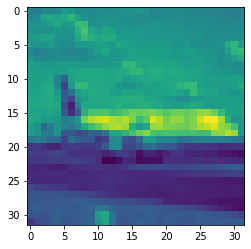

In [44]:
from matplotlib import pyplot as plt
fig = plt.figure
plt.imshow(data[0][4][2])


In [45]:
data[1].shape

torch.Size([64])

In [46]:
data[1]

tensor([9, 8, 3, 8, 0, 0, 1, 6, 4, 2, 9, 0, 2, 2, 3, 3, 7, 1, 7, 6, 9, 4, 7, 6,
        6, 5, 5, 0, 3, 8, 9, 1, 4, 7, 1, 0, 6, 5, 9, 9, 2, 9, 8, 5, 7, 1, 3, 6,
        1, 7, 0, 6, 1, 1, 8, 1, 2, 3, 3, 9, 5, 9, 1, 0])

In [47]:
if __name__ == "__main__":
    args = get_args()

    datamodule = LitCifar10(batch_size=args.batch_size,
                            patch_num=args.patch_num, 
                            num_workers=args.num_workers * args.devices)
    datamodule.prepare_data()

    data = iter(datamodule.train_dataloader()).next()
    patch_dim = data[0].shape[-1]
    seqlen = data[0].shape[-2]
    print("Embed dim:", args.embed_dim)
    print("Patch size:", 32 // args.patch_num)
    print("Sequence length:", seqlen)


    model = LitTransformer(num_classes=10, lr=args.lr, epochs=args.max_epochs, 
                           depth=args.depth, embed_dim=args.embed_dim, head=args.num_heads,
                           patch_dim=patch_dim, seqlen=seqlen,)

    trainer = Trainer(accelerator=args.accelerator, devices=args.devices,
                      max_epochs=args.max_epochs, precision=16 if args.accelerator == 'gpu' else 32,)
    trainer.fit(model, datamodule=datamodule)

____________________ datamodule init
____________________ datamodule prepare data
Files already downloaded and verified
Files already downloaded and verified
____________________ datamodule train dataloader
________________________________________ ________________________________________________________________________________________________________________________datamodule collate fn ____________________ ____________________ ____________________ ____________________datamodule collate fn________________________________________    ____________________datamodule collate fn____________________datamodule collate fn   

datamodule collate fn  datamodule collate fndatamodule collate fndatamodule collate fn 
datamodule collate fn 
datamodule collate fndatamodule collate fndatamodule collate fndatamodule collate fndatamodule collate fn
torch.Size([64, 3, 32, 32])

torch.Size([64, 3, 32, 32])
datamodule collate fndatamodule collate fn

torch.Size([64, 3, 32, 32])



torch.Size([64, 3, 32, 32]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Embed dim: 128
Patch size: 4
Sequence length: 32
____________________ init
____________________ reset param
____________________ datamodule prepare data
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | Transformer      | 2.4 M 
1 | embed   | Linear           | 4.2 K 
2 | fc      | Linear           | 41.0 K
3 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
4.840     Total estimated model params size (MB)


____________________ config optimizers
Sanity Checking: 0it [00:00, ?it/s]____________________ datamodule valdataloader
____________________ datamodule test dataload
____________________ datamodule collate fn____________________
________________________________________   torch.Size([64, 3, 32, 32])datamodule collate fndatamodule collate fndatamodule collate fn



torch.Size([64, 3, 32, 32])torch.Size([64, 3, 32, 32])torch.Size([64, 3, 32, 32])

xhsape
xhsapexhsape torch.Size([64, 3, 32, 32])torch.Size([64, 3, 32, 32])____________________xhsape________________________________________________________________________________
____________________  ____________________  datamodule collate fn yhsape 
torch.Size([64, 3, 32, 32])datamodule collate fn
  
torch.Size([64, 3, 32, 32]) torch.Size([64])yhsape ____________________torch.Size([64, 3, 32, 32])datamodule collate fn____________________ 
datamodule collate fn

 ____________________ 
torch.Size([64])____________________torch.Size([64, 3, 32

ValueError: too many values to unpack (expected 3)